# Dependencies

In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 11.9 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.7 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


# Setup & Imports

In [4]:
# Basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.colors as mcolors
import shap
import cv2

# Reproducibility
np.random.seed(42)

# Load Trajectory Data

✅ Loaded 113 sperm trajectories


,time,x,y,v_x,v_y,sperm_id,sheet_name
0,0.020833,569,410,0.0,0.0,0,ID_0_Normal Sperm
1,0.041667,578,417,168.0,120.0,0,ID_0_Normal Sperm
2,0.062500,578,417,96.0,96.0,0,ID_0_Normal Sperm
3,0.083333,578,417,0.0,0.0,0,ID_0_Normal Sperm
4,0.104167,578,417,0.0,0.0,0,ID_0_Normal Sperm


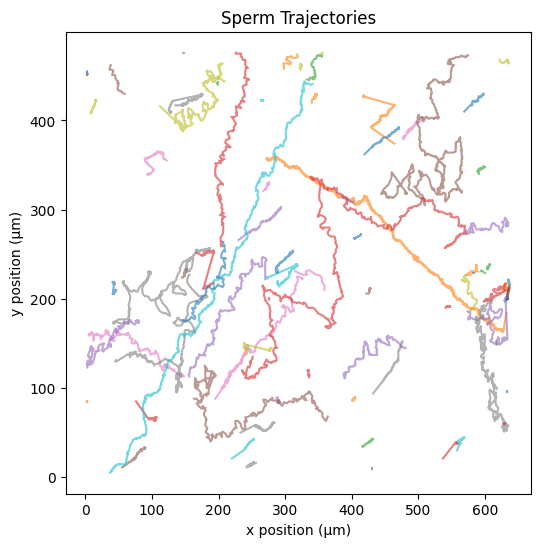

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import re  # for extracting ID number from sheet name

# 📂 Path to your Excel file
file_path = "/Users/mano/Documents/AI in Medicine/Trajectories Folder/35.xlsx"

# 🔹 Read all sheets
xls = pd.ExcelFile(file_path)

# Combine all sheets into one DataFrame
trajectory_list = []

for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    
    # Standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Extract sperm ID from sheet name (e.g., "ID_0_Normal Sperm" → "ID_0")
    match = re.search(r"ID_(\d+)", sheet_name)
    sperm_id = int(match.group(1)) if match else sheet_name
    
    df["sperm_id"] = sperm_id
    df["sheet_name"] = sheet_name  # optional, for traceability
    
    trajectory_list.append(df)

# Combine all trajectories
trajectory_data = pd.concat(trajectory_list, ignore_index=True)

print(f"✅ Loaded {len(xls.sheet_names)} sperm trajectories")
display(trajectory_data.head())

plt.figure(figsize=(6,6))
for sid, group in trajectory_data.groupby('sperm_id'):
    plt.plot(group['x'], group['y'], alpha=0.6)
plt.title("Sperm Trajectories")
plt.xlabel("x position (µm)")
plt.ylabel("y position (µm)")
plt.show()

# CASA Parameters

In [18]:
def compute_casa_params(df):
    casa = []
    for sid, sperm in df.groupby("sperm_id"):
        dx = np.diff(sperm['x'])
        dy = np.diff(sperm['y'])
        distance = np.sqrt(dx**2 + dy**2)
        time = len(dx)
        
        VCL = np.sum(distance) / time
        VSL = np.sqrt((sperm['x'].iloc[-1] - sperm['x'].iloc[0])**2 + 
                      (sperm['y'].iloc[-1] - sperm['y'].iloc[0])**2) / time
        LIN = (VSL / VCL) * 100 if VCL != 0 else 0
        STR = LIN  # approximate if direct angle not available
        
        casa.append([sid, VCL, VSL, LIN, STR])
    
    return pd.DataFrame(casa, columns=['Sperm_ID', 'VCL', 'VSL', 'LIN', 'STR'])

casa_df = compute_casa_params(trajectory_data)
print("CASA parameter summary:")
display(casa_df.describe())

CASA parameter summary:


/var/folders/1d/v3xlkt_j28l0r070b4ls10440000gn/T/ipykernel_82790/3395250764.py:9: RuntimeWarning: invalid value encountered in scalar divide
  VCL = np.sum(distance) / time
/var/folders/1d/v3xlkt_j28l0r070b4ls10440000gn/T/ipykernel_82790/3395250764.py:10: RuntimeWarning: invalid value encountered in scalar divide
  VSL = np.sqrt((sperm['x'].iloc[-1] - sperm['x'].iloc[0])**2 +


,Sperm_ID,VCL,VSL,LIN,STR
count,113.00000,95.000000,95.000000,95.000000,95.000000
mean,56.00000,0.961724,0.530288,30.290762,30.290762
std,32.76431,2.059576,1.991718,27.929813,27.929813
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,28.00000,0.141956,0.014882,7.702482,7.702482
50%,56.00000,0.277245,0.063729,20.972577,20.972577
75%,84.00000,1.316548,0.352247,44.754640,44.754640
max,112.00000,18.973666,18.973666,100.000000,100.000000


# Classification (Motility Categories)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.25      0.27      0.26        11
           2       0.00      0.00      0.00         9

    accuracy                           0.38        34
   macro avg       0.25      0.33      0.28        34
weighted avg       0.29      0.38      0.33        34



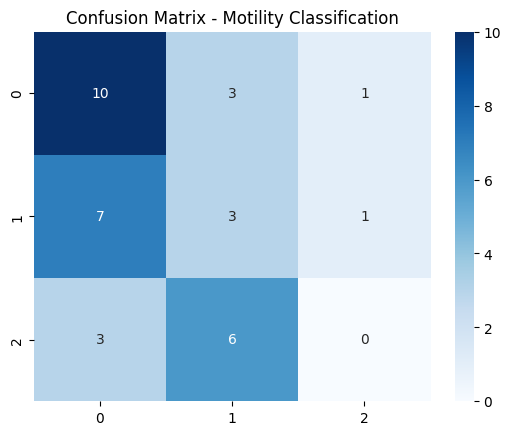

In [22]:
# Mock labeling or import labels from VISEM-style dataset
# Labels: 0=immotile, 1=non-progressive, 2=progressive
casa_df['Motility_Label'] = np.random.choice([0,1,2], size=len(casa_df))

X = casa_df[['VCL', 'VSL', 'LIN', 'STR']]
y = casa_df['Motility_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
plt.title("Confusion Matrix - Motility Classification")
plt.show()

# Explainable AI (XAI using SHAP)

/var/folders/1d/v3xlkt_j28l0r070b4ls10440000gn/T/ipykernel_82790/1884946491.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


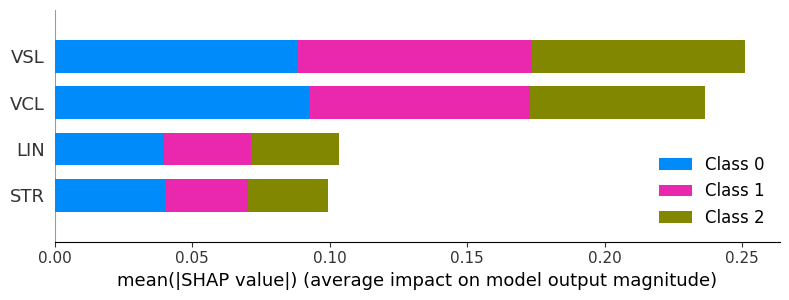

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (4, 3)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [23]:
explainer = shap.Explainer(clf, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Sample-wise explanation
sample_idx = 5
shap.plots.waterfall(shap_values[sample_idx])

# Validation Across Donors

In [24]:
# If donor info is available
casa_df['Donor_ID'] = np.random.choice(['D1','D2','D3','D4'], size=len(casa_df))
val_results = []

for donor, group in casa_df.groupby('Donor_ID'):
    X_d = group[['VCL', 'VSL', 'LIN', 'STR']]
    y_d = group['Motility_Label']
    y_pred_d = clf.predict(scaler.transform(X_d))
    acc = accuracy_score(y_d, y_pred_d)
    val_results.append([donor, acc])

val_df = pd.DataFrame(val_results, columns=['Donor_ID', 'Accuracy'])
print("Validation across donors:")
display(val_df)

Validation across donors:


,Donor_ID,Accuracy
0,D1,0.617647
1,D2,0.708333
2,D3,0.843750
3,D4,0.739130


# CASA Parameter Distributions

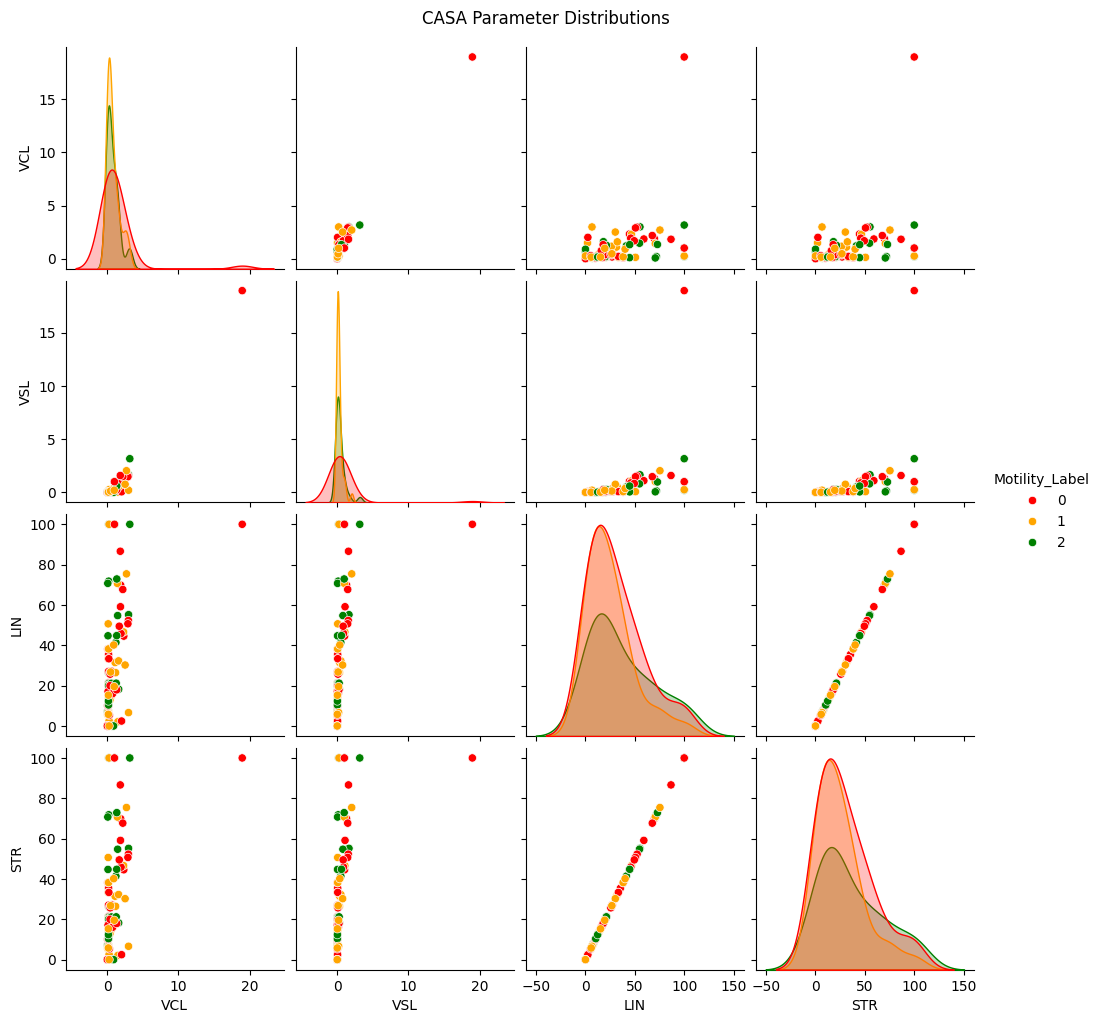

In [29]:
sns.pairplot(casa_df, vars=['VCL', 'VSL', 'LIN', 'STR'], hue='Motility_Label', palette=colors)
plt.suptitle("CASA Parameter Distributions", y=1.02)
plt.show()


# Report Generation

In [31]:
summary = {
    "Overall Accuracy": accuracy_score(y_test, y_pred),
    "Avg Donor Accuracy": val_df['Accuracy'].mean(),
    "Best Feature": X.columns[np.argmax(clf.feature_importances_)],
}

report_df = pd.DataFrame([summary])
report_df.to_csv("Sample Report.csv", index=False)
print("Report saved as 'Sample_Report.csv'")
display(report_df)

Report saved as 'Sample_Report.csv'


,Overall Accuracy,Avg Donor Accuracy,Best Feature
0,0.382353,0.727215,VCL
